<a href="https://colab.research.google.com/github/17239w/DL-ML/blob/main/%E6%B0%B4%E6%9E%9C%E5%88%86%E7%B1%BB%E5%99%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
!pip install numpy==1.23

2.15.0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print('Tensorflow version:')
!python3 -c 'import tensorflow as tf; print(tf.__version__)'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16050072151087120320
xla_global_id: -1
]
Tensorflow version:
2024-05-18 09:57:47.982985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 09:57:47.983046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 09:57:47.984553: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 09:57:49.292913: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2.15.0


In [ ]:
import datetime, os
import numpy as np
import matplotlib.pyplot as plt
import glob

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, InputLayer
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
precision, recall = Precision(), Recall()

# 下载数据集

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, files
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
googledrive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
id = '17T6-1E6Nk37O6S6sUhprQvTfLYmXQb-b'
download = googledrive.CreateFile({'id': id})
download.GetContentFile('2021_fruits_dataset.zip')
!unzip '2021_fruits_dataset.zip'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/175_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/176_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/177_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/178_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/179_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/180_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/181_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/182_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/183_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/184_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/185_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/186_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/187_100.jpg  
  inflating: 2021_fruits_dataset/3test/Onion Red Peeled/188_100

# 预处理图像，加载数据集

In [ ]:
class_names = ['apple', 'banana', 'cherry', 'grape', 'onion', 'peach', 'pear', 'pepper', 'plum', 'potato', 'tomato']

In [ ]:
# 将图像数据的数值范围重新调整到[0,1]
def im_preprocess(im):
    # 检查图像最大值是否大于1，如果是，认为图像的数据类型为uint8，需要转换为float
    if im.max() > 1.:
        # 将图像数据从0-255缩放到0-1，并转换为float16类型以节省内存
        im = np.divide(im, 255., dtype=np.float16)
    # 确保图像值在0到1之间
    assert im.max() <= 1.
    # 返回处理后的图像
    return im

# 加载数据集
def get_data(dataset, factor_downsample=0.5): # factor_downsample：按指定因子降采样，采用数据集的一半数据
    # 断言确保输入的数据集名称有效
    assert dataset in ['training', 'validation', 'testing']
    # 加载数据集
    print(f'Loading {dataset}-dataset')
    # 根据输入的数据集类型，确定相应的文件夹路径
    if dataset == 'training':
        home_folder = '2021_fruits_dataset/1training'
    elif dataset == 'validation':
        home_folder = '2021_fruits_dataset/2validation'
    else:
        home_folder = '2021_fruits_dataset/3test'

    # 初始化存储图像和标签的列表
    x = []
    y = []

    # 获取文件夹列表，并按字母顺序排序
    folder_list = sorted(os.listdir(home_folder))

    # 遍历每个子文件夹（代表一个类别）
    for folder in folder_list:
        folder_lower = folder.lower()  # 将文件夹名称转换为小写

        # 根据文件夹名称判断类别，并获取类别索引
        if 'apple' == folder_lower[:5]:
            y_index = class_names.index('apple')
        elif 'banana' in folder_lower:
            y_index = class_names.index('banana')
        elif 'cherry' in folder_lower[:6]:
            y_index = class_names.index('cherry')
        elif 'grape ' in folder_lower:
            y_index = class_names.index('grape')
        elif 'onion' in folder_lower:
            y_index = class_names.index('onion')
        elif 'peach' in folder_lower:
            y_index = class_names.index('peach')
        elif 'pear' in folder_lower:
            y_index = class_names.index('pear')
        elif 'pepper' in folder_lower:
            y_index = class_names.index('pepper')
        elif 'plum' in folder_lower:
            y_index = class_names.index('plum')
        elif 'potato' in folder_lower:
            y_index = class_names.index('potato')
        elif 'tomato' in folder_lower:
            y_index = class_names.index('tomato')
        else:
            # 如果遇到未知类别，抛出异常
            raise ValueError(f'Unknown class in {folder_lower}')
            continue

        # 获取当前类别文件夹内的所有文件
        folder_path = os.path.join(home_folder, folder)
        file_list = sorted(os.listdir(folder_path))
        # 遍历每个图像文件
        for im_file in file_list:
            # 解析文件名获取图像索引
            name, _ = os.path.splitext(im_file)
            # 图像索引
            index_file = int(name.split('_')[-2])
            # 如果图像索引不是降采样因子的整数倍，则跳过
            if (index_file % factor_downsample) != 0:
                continue
            # 构造图像的完整路径
            im_path = os.path.join(folder_path, im_file)
            # 读取并预处理图像
            im = plt.imread(im_path)
            im = im_preprocess(im)
            # 将预处理后的图像和对应的类别索引添加到列表中
            x.append(im)
            y.append(y_index)
    # 完成数据集加载
    print(f'Finished {dataset}-dataset')
    # 返回图像和标签列表
    return x, y

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# 判断不同类的样本是否分布均衡
def is_balanced(class_counts, threshold=0.1):
    total_samples = sum(class_counts.values())
    mean_samples = total_samples / len(class_counts)
    for count in class_counts.values():
        if abs(count - mean_samples) > mean_samples * threshold:
            return False
    return True

print('All class names:', class_names)
print('Training data')
try:
    x_train, y_train = get_data('training', factor_downsample=0.5)
    x_valid, y_valid = get_data('validation', factor_downsample=0.5)
    x_test, y_test = get_data('testing', factor_downsample=0.5)

    # 打印数据集信息的函数
    def print_dataset_info(x_data, y_data, dataset_name):
        print(f"{dataset_name} size: {len(x_data)}")
        class_counts = {class_name: 0 for class_name in class_names}
        for label in y_data:
            class_counts[class_names[label]] += 1
        for class_name, count in class_counts.items():
            print(f"Class {class_name} has {count} samples in {dataset_name}")

        # 判断是否均衡并打印结果
        if is_balanced(class_counts):
            print(f"The {dataset_name} is balanced.")
        else:
            print(f"The {dataset_name} is not balanced.")

    # 打印训练集、验证集和测试集的信息
    print_dataset_info(x_train, y_train, 'Training dataset')
    print_dataset_info(x_valid, y_valid, 'Validation dataset')
    print_dataset_info(x_test, y_test, 'Testing dataset')

    # 获取图像大小，假设所有数据集中的图像大小相同
    image_size = x_train[0].shape if x_train.size else None
    print("Image size:", image_size)

except Exception as e:
    print("Error loading or processing data:", str(e))

All class names: ['apple', 'banana', 'cherry', 'grape', 'onion', 'peach', 'pear', 'pepper', 'plum', 'potato', 'tomato']
Training data
Loading training-dataset
Finished training-dataset
Loading validation-dataset
Finished validation-dataset
Loading testing-dataset
Finished testing-dataset
Training dataset size: 20685
Class apple has 4330 samples in Training dataset
Class banana has 959 samples in Training dataset
Class cherry has 2296 samples in Training dataset
Class grape has 2296 samples in Training dataset
Class onion has 900 samples in Training dataset
Class peach has 1148 samples in Training dataset
Class pear has 2426 samples in Training dataset
Class pepper has 1184 samples in Training dataset
Class plum has 1212 samples in Training dataset
Class potato has 1206 samples in Training dataset
Class tomato has 2728 samples in Training dataset
The Training dataset is not balanced.
Validation dataset size: 10317
Class apple has 2164 samples in Validation dataset
Class banana has 478 s

In [ ]:
import os
from PIL import Image

# 指定数据集的基本路径
base_path = '2021_fruits_dataset/1training'
apple_folders = [d for d in os.listdir(base_path) if 'Apple' in d and os.path.isdir(os.path.join(base_path, d))]
banana_folders = [d for d in os.listdir(base_path) if 'Banana' in d and os.path.isdir(os.path.join(base_path, d))]
cherry_folders = [d for d in os.listdir(base_path) if 'Cherry' in d and os.path.isdir(os.path.join(base_path, d))]
grape_folders = [d for d in os.listdir(base_path) if 'Grape' in d and os.path.isdir(os.path.join(base_path, d))]
onion_folders = [d for d in os.listdir(base_path) if 'Onion' in d and os.path.isdir(os.path.join(base_path, d))]
peach_folders = [d for d in os.listdir(base_path) if 'Peach' in d and os.path.isdir(os.path.join(base_path, d))]
pear_folders = [d for d in os.listdir(base_path) if 'Pear' in d and os.path.isdir(os.path.join(base_path, d))]
pepper_folders = [d for d in os.listdir(base_path) if 'Pepper' in d and os.path.isdir(os.path.join(base_path, d))]
plum_folders = [d for d in os.listdir(base_path) if 'Plum' in d and os.path.isdir(os.path.join(base_path, d))]
potato_folders = [d for d in os.listdir(base_path) if 'Potato' in d and os.path.isdir(os.path.join(base_path, d))]
tomato_folders = [d for d in os.listdir(base_path) if 'Tomato' in d and os.path.isdir(os.path.join(base_path, d))]

# 展示出每类的一张图片
# 检查是否有找到苹果类文件夹
if apple_folders:
    first_apple_folder = apple_folders[0]
    folder_path = os.path.join(base_path, first_apple_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_apple_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_apple_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘Apple’的文件夹。")

# 检查是否有找到香蕉类文件夹
if banana_folders:
    first_banana_folder = banana_folders[0]
    folder_path = os.path.join(base_path, first_banana_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_banana_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_banana_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘banana’的文件夹。")

# 检查是否有找到樱桃类文件夹
if cherry_folders:
    first_cherry_folder = cherry_folders[0]
    folder_path = os.path.join(base_path, first_cherry_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_cherry_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_cherry_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘cherry’的文件夹。")

# 检查是否有找到葡萄类文件夹
if grape_folders:
    first_grape_folder = grape_folders[0]
    folder_path = os.path.join(base_path, first_grape_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_grape_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_grape_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘grape’的文件夹。")

# 检查是否有找到洋葱类文件夹
if onion_folders:
    first_onion_folder = onion_folders[0]
    folder_path = os.path.join(base_path, first_onion_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_onion_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_onion_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘onion’的文件夹。")

# 检查是否有找到桃子类文件夹
if peach_folders:
    first_peach_folder = peach_folders[0]
    folder_path = os.path.join(base_path, first_peach_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_peach_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_peach_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘peach’的文件夹。")

# 检查是否有找到梨类文件夹
if pear_folders:
    first_pear_folder = pear_folders[0]
    folder_path = os.path.join(base_path, first_pear_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_pear_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_pear_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘pear’的文件夹。")

# 检查是否有找到胡椒类文件夹
if pepper_folders:
    first_pepper_folder = pepper_folders[0]
    folder_path = os.path.join(base_path, first_pepper_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_pepper_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_pepper_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘pepper’的文件夹。")

# 检查是否有找到李子类文件夹
if plum_folders:
    first_plum_folder = plum_folders[0]
    folder_path = os.path.join(base_path, first_plum_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_plum_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_plum_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘plum’的文件夹。")

# 检查是否有找到土豆类文件夹
if potato_folders:
    first_potato_folder = potato_folders[0]
    folder_path = os.path.join(base_path, first_potato_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_potato_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_potato_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘potato’的文件夹。")

# 检查是否有找到番茄类文件夹
if tomato_folders:
    first_tomato_folder = tomato_folders[0]
    folder_path = os.path.join(base_path, first_tomato_folder)
    # 获取文件夹中的所有文件
    images = [img for img in os.listdir(folder_path) if img.lower().endswith(('jpg'))]
    if images:
        first_image = images[0]
        image_path = os.path.join(folder_path, first_image)
        # 使用PIL打开并显示图像
        image = Image.open(image_path)
        # 保存图像到本地
        image.save('first_tomato_image.jpg')
        print(f"图片已保存到：{os.path.abspath('first_tomato_image.jpg')}")
    else:
        print("在该文件夹中没有找到图片。")
else:
    print("没有找到包含‘tomato’的文件夹。")

图片已保存到：/content/first_apple_image.jpg
图片已保存到：/content/first_banana_image.jpg
图片已保存到：/content/first_cherry_image.jpg
图片已保存到：/content/first_grape_image.jpg
图片已保存到：/content/first_onion_image.jpg
图片已保存到：/content/first_peach_image.jpg
图片已保存到：/content/first_pear_image.jpg
图片已保存到：/content/first_pepper_image.jpg
图片已保存到：/content/first_plum_image.jpg
图片已保存到：/content/first_potato_image.jpg
图片已保存到：/content/first_tomato_image.jpg


# 设置索引

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# 将多个numpy数组沿着第0轴（批次维度）堆叠起来，并转换为16位浮点数格式
x_train = np.stack(x_train, axis=0).astype(np.float16)
x_valid = np.stack(x_valid, axis=0).astype(np.float16)
x_test = np.stack(x_test, axis=0).astype(np.float16)

# 将标签数组也沿着第0轴堆叠起来，并转换为16位整数格式
y_train = np.stack(y_train, axis=0).astype(np.int16)
y_valid = np.stack(y_valid, axis=0).astype(np.int16)
y_test = np.stack(y_test, axis=0).astype(np.int16)

# 创建一个索引列表，用于访问训练集中的数据
index = [i for i in range(len(x_train))]
# 设置随机种子以确保可重复性
np.random.seed(10)
# 打乱索引
np.random.shuffle(index)
# 选取一半的索引进行训练
selected_index = index[0: int(len(index)/2)]
# 使用选定的索引来更新训练集数据
x_train = x_train[selected_index,:,:,:]
y_train = y_train[selected_index]

# 为验证集创建一个索引列表
index_valid = [i for i in range(len(x_valid))]
# 设置相同的随机种子以确保与训练集相同的随机性
np.random.seed(10)
# 打乱索引
np.random.shuffle(index_valid)
# 选取一半的索引进行验证
selected_index_valid = index_valid[0: int(len(index_valid)/2)]
# 使用选定的索引来更新验证集数据
x_valid = x_valid[selected_index_valid,:,:,:]
y_valid = y_valid[selected_index_valid]

# 为测试集创建一个索引列表
index_test = [i for i in range(len(x_test))]
# 设置相同的随机种子以确保与训练集和验证集相同的随机性
np.random.seed(10)
# 打乱索引
np.random.shuffle(index_test)
# 选取一半的索引进行测试
selected_index_test = index_test[0: int(len(index_test)/2)]
# 使用选定的索引来更新测试集数据
x_test = x_test[selected_index_test,:,:,:]
y_test = y_test[selected_index_test]

# # 定义一个函数，将类标签数组转换为苹果类的二进制数组
def y_to_apple(y):
    i_apple = class_names.index('apple')  # 获取苹果类的索引
    y_apple = np.equal(y, i_apple).astype(np.int16)  # 将所有苹果类标签设为1，其余设为0
    return y_apple

# 二分类标签
y_train_apple = y_to_apple(y_train)
y_valid_apple = y_to_apple(y_valid)
y_test_apple = y_to_apple(y_test)

# 多分类标签
y_train_fruit = to_categorical(y_train, num_classes=11)
y_valid_fruit = to_categorical(y_valid, num_classes=11)
y_test_fruit = to_categorical(y_test, num_classes=11)

# 构建CNN

In [ ]:
# 设置一个变量pract_folder，为在Google Drive上存储项目相关文件的文件夹路径
pract_folder = 'drive/My Drive/AI_pract3_nn2021'
# 将pract_folder路径与子目录'logs'合并，创建一个新的路径存储日志文件
logs_folder = os.path.join(pract_folder, 'logs')
# 同样，将pract_folder路径与子目录'weights'合并，创建一个新的路径用于存储模型权重文件
weights_folder = os.path.join(pract_folder, 'weights')
# 检查weights_folder路径是否已存在
if not os.path.exists(weights_folder):
    # 如果weights_folder路径不存在，使用os.makedirs函数创建这个目录
    os.makedirs(weights_folder)

## 构建苹果分类器和水果分类器

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Precision, Recall

def get_model_base_simple(k=4):
    model = Sequential()
    model.epoch = 0
    model.add(InputLayer((100, 100, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2))) # downsampling
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(k, (4, 4), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(k, activation='elu'))
    return model

# 苹果分类器
def get_model_apple_simple(optimizer, loss='mse'):
    model = get_model_base_simple()
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss,
           optimizer=optimizer,
           metrics=['accuracy', Precision(), Recall()])
    return model

# 水果分类器
def get_model_fruit_simple(optimizer, loss='categorical_crossentropy'):
    num_classes = 11 # 共11类水果
    model = get_model_base_simple()
    # 将激活函数更改为softmax以支持多分类
    model.add(Dense(11, activation='softmax'))
    model.compile(loss=loss,
           optimizer=optimizer,
           metrics=['accuracy', Precision(), Recall()])
    return model

# 苹果分类器的模型定义
# 创建使用SGD的模型
model_apple_sgd = get_model_apple_simple(SGD(lr=0.01))
model_apple_sgd.summary()
# 创建使用Adam的模型
model_apple_adam = get_model_apple_simple(Adam(lr=0.001))
model_apple_adam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (Average  (None, 50, 50, 3)         0         
 Pooling2D)                                                      
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 4)         112       
                                                                 
 average_pooling2d_1 (Avera  (None, 24, 24, 4)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 4)         148       
                                                                 
 average_pooling2d_2 (Avera  (None, 11, 11, 4)         0         
 gePooling2D)                                                    
                                                        

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_4 (Avera  (None, 50, 50, 3)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 4)         112       
                                                                 
 average_pooling2d_5 (Avera  (None, 24, 24, 4)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 4)         148       
                                                                 
 average_pooling2d_6 (Avera  (None, 11, 11, 4)         0         
 gePooling2D)                                                    
                                                      

# 第二问 苹果分类

## 训练苹果分类器

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 设置早停法来避免过拟合
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',   # 监控验证集的损失
    patience=5,           # 在5个epoch内如果没有改善则停止训练
    verbose=1,            # 打印详细日志
    restore_best_weights=True  # 恢复到最佳模型权重
)

# 训练使用SGD优化器的模型
history_sgd = model_apple_sgd.fit(
    x_train, y_train_apple,
    validation_data=(x_valid, y_valid_apple),
    batch_size=32,  # 指定批量大小
    epochs=20,      # 指定训练轮数
    callbacks=[early_stopping_monitor]  # 添加早停法
)

# 训练使用Adam优化器的模型
history_adam = model_apple_adam.fit(
    x_train, y_train_apple,
    validation_data=(x_valid, y_valid_apple),
    batch_size=32,  # 指定批量大小
    epochs=20,      # 指定训练轮数
    callbacks=[early_stopping_monitor]  # 添加早停法
)

y_test_pred = model_apple_sgd.predict(x_test)

Epoch 1/20
324/324 [==============================] - 24s 72ms/step - loss: 0.1691 - accuracy: 0.7875 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.1616 - val_accuracy: 0.7850 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
324/324 [==============================] - 22s 68ms/step - loss: 0.1529 - accuracy: 0.7892 - precision: 1.0000 - recall: 0.0050 - val_loss: 0.1418 - val_accuracy: 0.8065 - val_precision: 1.0000 - val_recall: 0.1001
Epoch 3/20
324/324 [==============================] - 22s 67ms/step - loss: 0.1283 - accuracy: 0.8426 - precision: 0.8970 - recall: 0.2903 - val_loss: 0.1185 - val_accuracy: 0.8573 - val_precision: 0.8385 - val_recall: 0.4166
Epoch 4/20
324/324 [==============================] - 21s 65ms/step - loss: 0.1148 - accuracy: 0.8636 - precision: 0.8464 - recall: 0.4350 - val_loss: 0.1120 - val_accuracy: 0.8709 - val_precision: 0.7814 - val_recall: 0.5546
Epoch 5/20
324/324 [==============================] - 26s 81ms/step - loss: 0.11

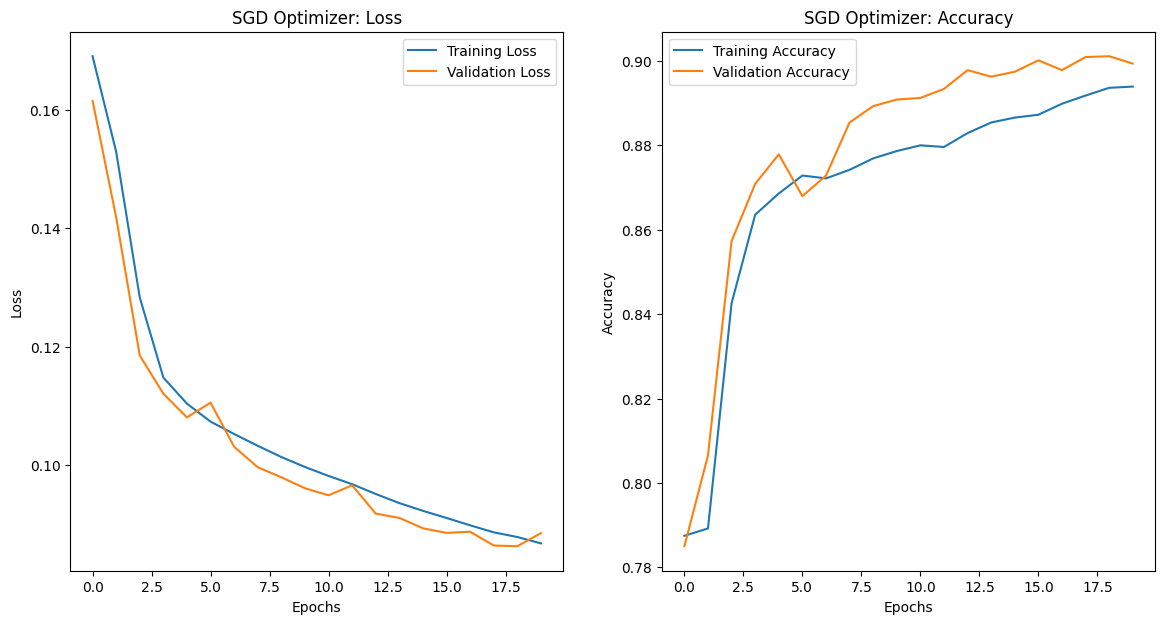

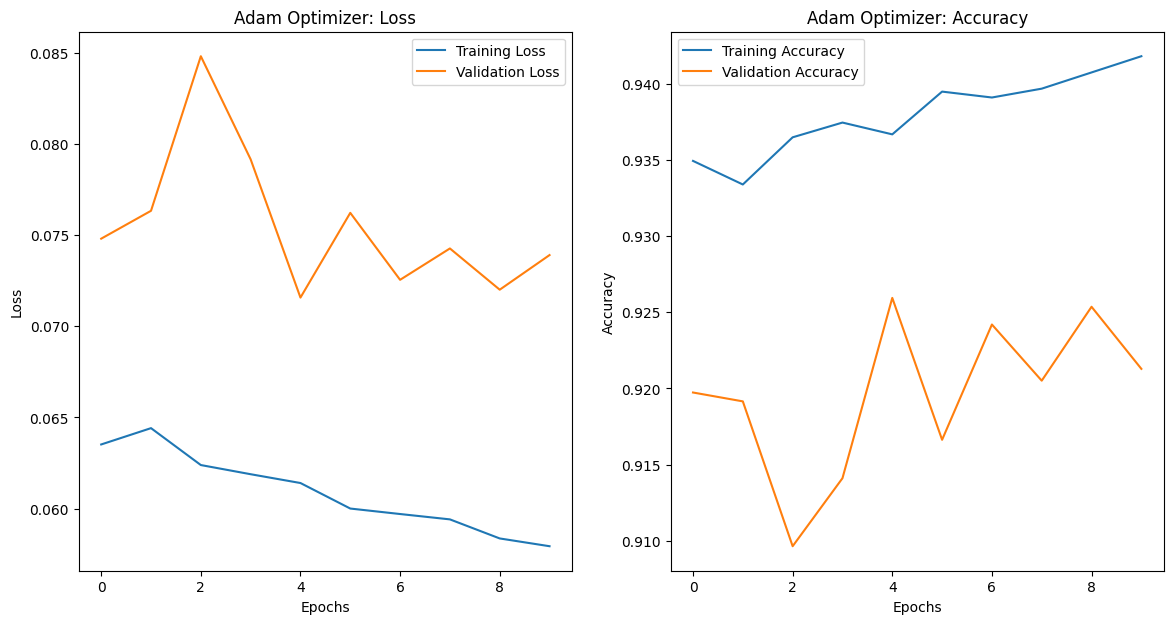

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    # 绘制训练集和验证集的损失
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title}: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练集和验证集的精度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title}: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# 绘制使用SGD优化器的模型的性能
plot_history(history_sgd, "SGD Optimizer")

# 绘制使用Adam优化器的模型的性能
plot_history(history_adam, "Adam Optimizer")

## 基于验证集判断苹果分类模型准确率

162/162 [==============================] - 5s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4049
           1       0.00      0.00      0.00      1109

    accuracy                           0.78      5158
   macro avg       0.39      0.50      0.44      5158
weighted avg       0.62      0.78      0.69      5158



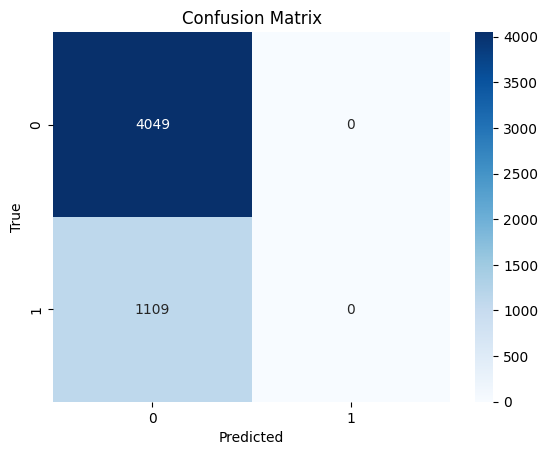

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# # SGD优化器
# # 对验证集进行预测
# y_valid_pred_sgd = model_apple_sgd.predict(x_valid)
# y_valid_pred_sgd = np.argmax(y_valid_pred_sgd, axis=1)  # 如果是多类别分类
# # 打印分类报告(准确率、召回率、F1-score)
# print(classification_report(y_valid_apple, y_valid_pred_sgd))
# # 计算混淆矩阵
# conf_matrix_sgd = confusion_matrix(y_valid_apple, y_valid_pred_sgd)
# # 绘制混淆矩阵
# sns.heatmap(conf_matrix_sgd, annot=True, fmt='d', cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.title('Confusion Matrix')
# plt.show()


# ADAM优化器
# 对验证集进行预测
y_valid_pred_adam = model_apple_adam.predict(x_valid)
y_valid_pred_adam = np.argmax(y_valid_pred_adam, axis=1)  # 如果是多类别分类
# 打印分类报告(准确率、召回率、F1-score)
print(classification_report(y_valid_apple, y_valid_pred_adam))
# 计算混淆矩阵
conf_matrix_adam = confusion_matrix(y_valid_apple, y_valid_pred_adam)
# 绘制混淆矩阵
sns.heatmap(conf_matrix_adam, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 第三问 水果分类

## 训练水果分类器

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

def get_model_base_simple(k=4):
    model = Sequential()
    model.epoch = 0
    model.add(InputLayer((100, 100, 3)))
    model.add(AveragePooling2D(pool_size=(2, 2)))  # downsampling
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(k, (3, 3), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Conv2D(k, (4, 4), activation='elu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(k, activation='elu'))
    return model

# 水果分类器
def get_model_fruit_simple(optimizer, loss='categorical_crossentropy'):
    num_classes = 11  # 共11类水果
    model = get_model_base_simple()
    # 将激活函数更改为softmax以支持多分类
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=[CategoricalAccuracy(), Precision(), Recall()])
    return model

# 创建使用Adam的模型
model_fruit_adam = get_model_fruit_simple(Adam(learning_rate=0.001))
model_fruit_adam.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (Average  (None, 50, 50, 3)         0         
 Pooling2D)                                                      
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 4)         112       
                                                                 
 average_pooling2d_1 (Avera  (None, 24, 24, 4)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 4)         148       
                                                                 
 average_pooling2d_2 (Avera  (None, 11, 11, 4)         0         
 gePooling2D)                                                    
                                                        

### 处理训练集和验证集

In [ ]:
import os
import shutil

def count_classes(directory):
    """计算指定目录下的类别数量。"""
    return len([name for name in os.listdir(directory) if os.path.isdir(os.path.join(directory, name))])

train_dir = '2021_fruits_dataset/1training'
validation_dir = '2021_fruits_dataset/2validation'

print("训练集类别数量:", count_classes(train_dir))
print("验证集类别数量:", count_classes(validation_dir))


训练集类别数量: 58
验证集类别数量: 58


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import keras

class CustomDataGenerator(Sequence):
    def __init__(self, images, labels, batch_size, num_classes):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        #return np.ceil(len(self.images) / float(self.batch_size)).astype(np.int)
        return int(np.ceil(len(self.images) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        return np.array(batch_x), keras.utils.to_categorical(batch_y, num_classes=self.num_classes)

# 假设 get_data 函数已经定义好，并且在当前作用域中可用
# 例如，使用 get_data('training') 来加载训练数据
x_train, y_train = get_data('training')
x_val, y_val = get_data('validation')

# 将列表转换为Numpy数组
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

# 创建自定义的数据生成器实例
train_generator = CustomDataGenerator(x_train, y_train, batch_size=32, num_classes=len(class_names))
validation_generator = CustomDataGenerator(x_val, y_val, batch_size=32, num_classes=len(class_names))

# 现在可以使用 train_generator 和 validation_generator 进行模型训练了

Loading training-dataset
Finished training-dataset
Loading validation-dataset
Finished validation-dataset


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# 模型参数
input_shape = (100, 100, 3)  # 更新为正确的输入形状
num_classes = 11  # 如果您有11个类别

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 使用正确的类别数量
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# 检查训练数据
for images, labels in train_generator:
    print(images.shape, labels.shape)
    break

# 检查验证数据
for images, labels in validation_generator:
    print(images.shape, labels.shape)
    break

# 训练参数
epochs = 10
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

try:
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )
except Exception as e:
    print(e)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

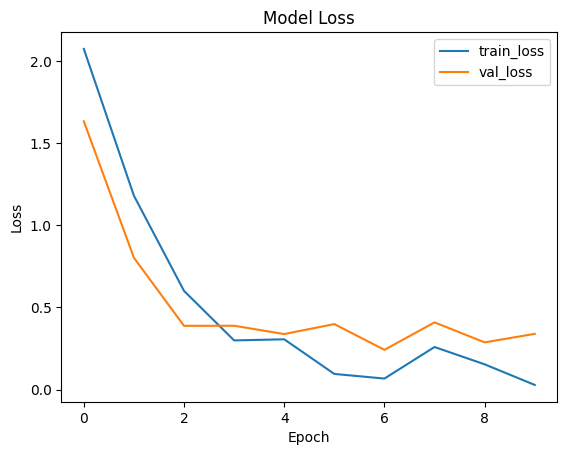

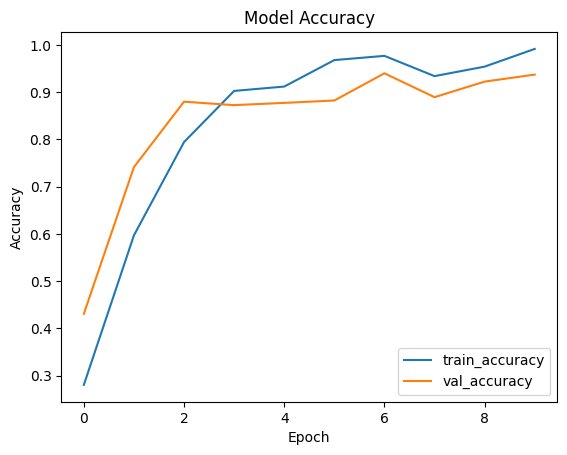

In [ ]:
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# 绘制训练精度和验证精度
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

## 基于收集的测试集判断模型准确率

Found 1500 images belonging to 5 classes.
47/47 [==============================] - 13s 281ms/step
分类精度: 0.16666666666666666
非归一化混淆矩阵


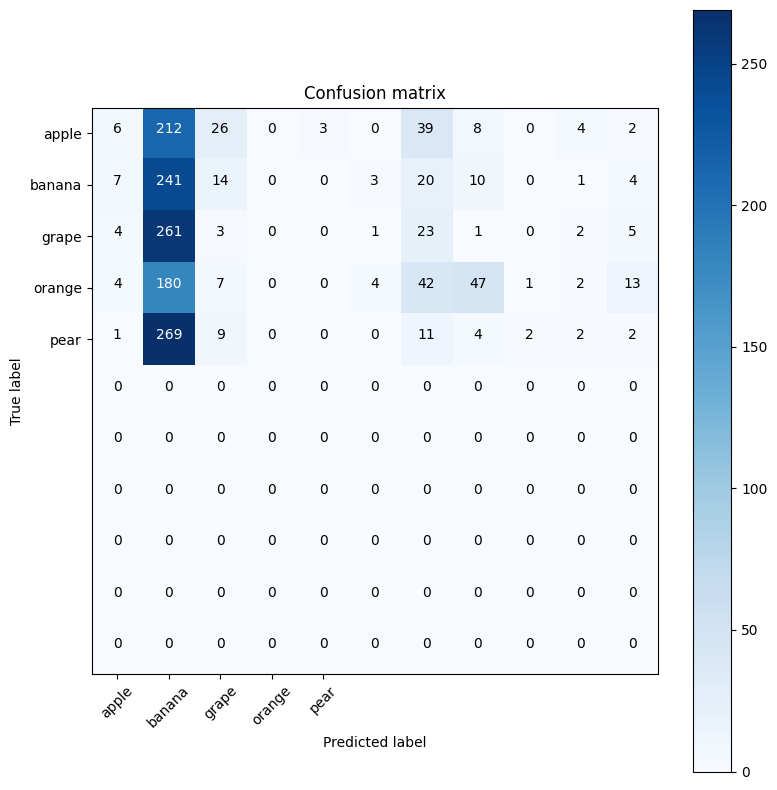

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools
import matplotlib.pyplot as plt

# 测试数据生成器
test_datagen = ImageDataGenerator(rescale=1./255)

# 测试集路径
test_data_dir = 'drive/MyDrive/fruits'

# 测试生成器
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(100, 100),  # 假设您的模型输入为100x100像素
    batch_size=32,  # 或您用于训练的批次大小
    class_mode='categorical',  # 因为我们是在做分类任务
    shuffle=False  # 不打乱顺序以便后面可以匹配标签和预测
)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("归一化混淆矩阵")
    else:
        print('非归一化混淆矩阵')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 获取测试数据所有真实标签
test_labels = test_generator.classes

# 获取类别标签的映射
label_map = (test_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())

# 计算steps，确保包含所有样本
steps = np.ceil(test_generator.n / test_generator.batch_size)

# 使用模型进行预测
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# 由于steps的向上取整，确保predicted_classes与test_labels长度一致
predicted_classes = predicted_classes[:len(test_labels)]

# 计算混淆矩阵
cm = confusion_matrix(test_labels, predicted_classes)

# 计算分类精度
accuracy = accuracy_score(test_labels, predicted_classes)

print('分类精度:', accuracy)

# 绘制混淆矩阵的函数保持不变

# 类别标签
classes = list(label_map.values())

# 绘制非归一化的混淆矩阵
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)
plt.show()